In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1000)

## 参数解释
- dims 包含两个值的元组（input_size, output_size）
- previous_layer 上一层的实例
- init_method 初始化方法
- activation 激活函数

In [2]:
class Layer:
    def __init__(self, dims, previous_layer=None, init_method='random_normal', activation='linear'):
        self.dims = dims
        self.activation_func = activation
        self.previous_layer = None
        self.outs = None
        self.ins = None
        if previous_layer is not None:
            if previous_layer.dims[1] != self.dims[0]:
                raise Exception("Layers can't be attached!, {} != {}".format(previous_layer.dims[1],self.dims[0]))
            self.weights = np.random.normal(size=self.dims)
            self.bias = np.random.normal(size=(self.dims[1]))
            self.previous_layer = previous_layer
        else:
            self.weights = np.random.normal(size=self.dims)
            self.bias = np.random.normal(size=(self.dims[1]))
    
    # 向前传递：输入 * 权重 + 偏差值
    def forward_prop(self,inputs):
        return inputs @ self.weights + self.bias
    
    # 激活函数：tanh
    def activation(self,inputs):
        if self.activation_func == 'tanh':
            return np.tanh(inputs)
        else:
            return inputs
    
    # 激活函数的导数：(tanh)' = 1 - tanh(x)^2
    def derivative_of_activation(self,inputs):
        if self.activation_func == 'tanh':
            return 1 - self.activation(inputs)**2
        elif self.activation_func == 'linear':
            return np.ones(inputs.shape)
        else:
            pass
    
    # 梯度下降：new = old - step_size * 梯度值
    def gradient_descent(self,grads_w, grads_b, steps):
        self.weights -= steps*grads_w
        self.bias -= steps*grads_b
    
    # 计算前一层的误差
    def calc_prev_layer_error(self,derivative,weights,error):
        N,M = derivative.shape
        Sum = np.zeros((M,N))
        for i in range(N):
            Is = np.zeros((N,N))
            Ir = np.zeros((N,N))
            Is[0][i] = 1
            Ir[i][i] = 1
            Sum += np.diag((Is @ derivative)[0][:]) @ ((weights @ error) @ Ir)
        return Sum
    
    # 向后传播
    def back_prop(self,error,steps):
        if self.previous_layer is None:
             
            #计算梯度
            grads_w = error @ self.ins
            grads_b = np.sum(error,axis=1)
            
            #利用梯度更新权值
            self.gradient_descent(grads_w.T,grads_b,steps)
            
        else:
            #计算导数
            d = self.previous_layer.derivative_of_activation(self.previous_layer.outs)
            
            #计算先前层的误差
            layer_error = self.calc_prev_layer_error(d,self.weights,error)
             
            #计算梯度
            grads_w = error @ self.previous_layer.activation(self.ins)
            grads_b = np.sum(error,axis=1)
             
            self.gradient_descent(grads_w.T, grads_b, steps)
 
            self.previous_layer.back_prop(layer_error, steps)
         
         
    def __call__(self,inputs):
        if self.previous_layer is None:
            self.ins = inputs
            self.outs = self.forward_prop(self.ins)
            return self.activation(self.outs)
        else:
            self.ins = self.previous_layer(inputs)
            self.outs = self.forward_prop(self.ins)
            return self.activation(self.outs)

## Params
- generator   : 数据生成器实例
- epochs     : 时期数
- steps      : 梯度下降的步长

In [3]:
class Model:
    def __init__(self, network, loss_func='rms'):
        self.network = network
        self.loss_func = loss_func
        
    def fit(self, generator, epochs=10,steps=0.1):
        for epoch in range(epochs):
            x_train, y_train = next(generator)
            
            #向前传播
            y = self.network(x_train)
            error_sigma = self.loss(y,y_train)
            
            #向后传播
            self.network.back_prop(error_sigma,steps)
            Error = self.error(y,y_train)
            print("Epoch: {}  Error: {}".format(epoch,Error))
             
    def loss(self,y,t):
        if self.loss_func == 'rms':
            return (y - t).T
        elif self.loss_func == 'logits':
            pass
        
    # rms的计算方法
    def error(self,y,t):
        if self.loss_func == 'rms':
            e = (y - t)**2
            e = 0.5*np.mean(e)
            return np.sqrt(e)
         
    def predict(self,X_test):
        return self.network(X_test)

In [4]:
class Data:
    def __init__(self, x,y,batch_size):
        self.batch_size = batch_size
        self.x = x
        self.y = y
        
    def __next__(self):
        choices = np.random.choice(self.x.shape[0],self.batch_size)
        x_ = self.x[choices]
        y_ = self.y[choices]
        return x_, y_

In [5]:
# 产生数据
def f(x):
    return np.sin(2*x) + np.cos(x)+ 5
  
x = np.linspace(-5,5,1000).reshape(-1,1)
y = f(x)

# 数据集大小
N = 10000 
# 数据和参数的偏差
sigma_data = 0.2 
 
# 模拟噪声
data_noise = np.random.normal(0, sigma_data, N).reshape(-1,1)
 
# 产生训练数据
X_train = np.random.uniform(-5,5,N).reshape(-1,1)
Y_train = f(X_train) + data_noise

In [6]:
# Create network
L1 = Layer((1,12),activation='tanh')
L2 = Layer((12,32),L1, activation='tanh')
L3 = Layer((32,12),L2, activation='tanh')
network = Layer((12,1),L3)
 
model = Model(network)
batch_size = 100
datagen = Data(X_train,Y_train,batch_size)
 
#Training
model.fit(datagen,epochs=1000,steps=0.0001)

Epoch: 0  Error: 3.9048025904020425
Epoch: 1  Error: 3.1830467098291937
Epoch: 2  Error: 2.1734916938063895
Epoch: 3  Error: 1.8347583416889348
Epoch: 4  Error: 1.7260855741245216
Epoch: 5  Error: 1.3957928072402135
Epoch: 6  Error: 0.9264621836752951
Epoch: 7  Error: 0.800297614208198
Epoch: 8  Error: 0.865068662154362
Epoch: 9  Error: 0.7329435466119426
Epoch: 10  Error: 0.7705927685023714
Epoch: 11  Error: 0.7123002633002777
Epoch: 12  Error: 0.7206529208224294
Epoch: 13  Error: 0.7459805194738657
Epoch: 14  Error: 0.7939840436417579
Epoch: 15  Error: 0.6628380856640546
Epoch: 16  Error: 0.6772242976575075
Epoch: 17  Error: 0.7604268467611776
Epoch: 18  Error: 0.6928944931213199
Epoch: 19  Error: 0.7506510673894213
Epoch: 20  Error: 0.6728819176529839
Epoch: 21  Error: 0.7290304700367027
Epoch: 22  Error: 0.6686620282504991
Epoch: 23  Error: 0.6776354616668115
Epoch: 24  Error: 0.6609556955387033
Epoch: 25  Error: 0.6741505875714546
Epoch: 26  Error: 0.6337310846220845
Epoch: 27  Er

Epoch: 219  Error: 0.2473942728532225
Epoch: 220  Error: 0.22186930985557252
Epoch: 221  Error: 0.24409088192830192
Epoch: 222  Error: 0.271299160259224
Epoch: 223  Error: 0.23403420225135307
Epoch: 224  Error: 0.21622991359436347
Epoch: 225  Error: 0.24331706920826915
Epoch: 226  Error: 0.2864349598477337
Epoch: 227  Error: 0.2184994266177178
Epoch: 228  Error: 0.2637631868357681
Epoch: 229  Error: 0.2604138197606617
Epoch: 230  Error: 0.22504264180243583
Epoch: 231  Error: 0.2679289698642202
Epoch: 232  Error: 0.25695882574108436
Epoch: 233  Error: 0.21897894989854708
Epoch: 234  Error: 0.26895776377561886
Epoch: 235  Error: 0.2643963567856179
Epoch: 236  Error: 0.2535464646038151
Epoch: 237  Error: 0.2482004242093446
Epoch: 238  Error: 0.23134173881441314
Epoch: 239  Error: 0.2369027205810589
Epoch: 240  Error: 0.23693051989103742
Epoch: 241  Error: 0.2538164694599031
Epoch: 242  Error: 0.24499753261093812
Epoch: 243  Error: 0.2518688416507495
Epoch: 244  Error: 0.24091621954630113


Epoch: 434  Error: 0.22939298155422722
Epoch: 435  Error: 0.20707648741387294
Epoch: 436  Error: 0.17147776919395138
Epoch: 437  Error: 0.18919642430722133
Epoch: 438  Error: 0.2386051602350297
Epoch: 439  Error: 0.19007651046614868
Epoch: 440  Error: 0.15357593760232155
Epoch: 441  Error: 0.19271353820473408
Epoch: 442  Error: 0.19879683006479906
Epoch: 443  Error: 0.19296412282873077
Epoch: 444  Error: 0.1919202941925307
Epoch: 445  Error: 0.17530618455405197
Epoch: 446  Error: 0.2206690202192243
Epoch: 447  Error: 0.23351604698231104
Epoch: 448  Error: 0.20237692835933768
Epoch: 449  Error: 0.1740862124179235
Epoch: 450  Error: 0.20184556812599014
Epoch: 451  Error: 0.19399006795332707
Epoch: 452  Error: 0.1978781389915138
Epoch: 453  Error: 0.19718406418965032
Epoch: 454  Error: 0.16701739661877837
Epoch: 455  Error: 0.23354113491295778
Epoch: 456  Error: 0.183610023928517
Epoch: 457  Error: 0.1853743925880217
Epoch: 458  Error: 0.20522317719037017
Epoch: 459  Error: 0.179623961710

Epoch: 649  Error: 0.19936161687016452
Epoch: 650  Error: 0.17985525201286498
Epoch: 651  Error: 0.2038499600944182
Epoch: 652  Error: 0.19119949597723265
Epoch: 653  Error: 0.1711156638026011
Epoch: 654  Error: 0.18207900698268634
Epoch: 655  Error: 0.20076990068933798
Epoch: 656  Error: 0.21379512133600936
Epoch: 657  Error: 0.18669531800990202
Epoch: 658  Error: 0.16382361865888181
Epoch: 659  Error: 0.16771302063049837
Epoch: 660  Error: 0.17449822098806067
Epoch: 661  Error: 0.19010306304680766
Epoch: 662  Error: 0.19641047905392267
Epoch: 663  Error: 0.17767335841042295
Epoch: 664  Error: 0.18344084415656517
Epoch: 665  Error: 0.2042705519827076
Epoch: 666  Error: 0.1918463099689957
Epoch: 667  Error: 0.17732178430324383
Epoch: 668  Error: 0.21259315750226307
Epoch: 669  Error: 0.19501522896358495
Epoch: 670  Error: 0.19490531277901885
Epoch: 671  Error: 0.21300297284512917
Epoch: 672  Error: 0.18218197390698904
Epoch: 673  Error: 0.18397758822151714
Epoch: 674  Error: 0.19894508

Epoch: 865  Error: 0.2032964282835495
Epoch: 866  Error: 0.18898277355449974
Epoch: 867  Error: 0.17232496703249264
Epoch: 868  Error: 0.1575863625532988
Epoch: 869  Error: 0.16032128116738595
Epoch: 870  Error: 0.15269363191310273
Epoch: 871  Error: 0.18779399187720971
Epoch: 872  Error: 0.1767339940579682
Epoch: 873  Error: 0.19466076244110525
Epoch: 874  Error: 0.17140584026455016
Epoch: 875  Error: 0.184472290842906
Epoch: 876  Error: 0.16619078278781932
Epoch: 877  Error: 0.15962771956252522
Epoch: 878  Error: 0.15665782729863661
Epoch: 879  Error: 0.18677125575022915
Epoch: 880  Error: 0.1990356306968096
Epoch: 881  Error: 0.1907569785716526
Epoch: 882  Error: 0.20079219521477704
Epoch: 883  Error: 0.19852874977052387
Epoch: 884  Error: 0.19577449648981446
Epoch: 885  Error: 0.18161777946322546
Epoch: 886  Error: 0.1858537959791533
Epoch: 887  Error: 0.18375831878227827
Epoch: 888  Error: 0.19838281704907496
Epoch: 889  Error: 0.18068012600979305
Epoch: 890  Error: 0.186724245319

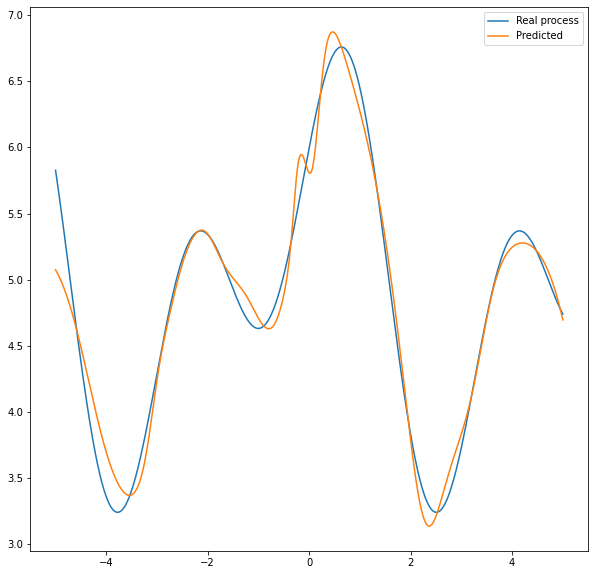

In [9]:
X_test = np.linspace(-5,5,1000).reshape(-1,1)
predicted = model.predict(X_test)
 
plt.figure(figsize=(10,10))
plt.plot(x,y,label="Real process")
plt.plot(X_test,predicted,label="Predicted")
plt.legend()
plt.show()